## Importing the required libraries

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn

## Reading the data

In [4]:
df = pd.read_csv("car.data", header = None)

## Data Exploration

In [5]:
df.shape

(1728, 7)

In [6]:
df.columns

Int64Index([0, 1, 2, 3, 4, 5, 6], dtype='int64')

In [7]:
df.head()

,0,1,2,3,4,5,6
0,vhigh,vhigh,2,2,small,low,unacc
1,vhigh,vhigh,2,2,small,med,unacc
2,vhigh,vhigh,2,2,small,high,unacc
3,vhigh,vhigh,2,2,med,low,unacc
4,vhigh,vhigh,2,2,med,med,unacc


*Renaming columns for better understandability*

In [8]:
df.columns = ['buying', 'maint', 'doors', 'persons', 'lug_boot', 'safety', 'class']

In [9]:
df.duplicated().sum()

0

*The data does not have duplicate records.*

In [10]:
df.isnull().sum()

buying      0
maint       0
doors       0
persons     0
lug_boot    0
safety      0
class       0
dtype: int64

*The data does not have have null values.*

In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1728 entries, 0 to 1727
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   buying    1728 non-null   object
 1   maint     1728 non-null   object
 2   doors     1728 non-null   object
 3   persons   1728 non-null   object
 4   lug_boot  1728 non-null   object
 5   safety    1728 non-null   object
 6   class     1728 non-null   object
dtypes: object(7)
memory usage: 94.6+ KB


*The results of data exploration are pretty much summarised by the df.info() command.*

## Visualisation

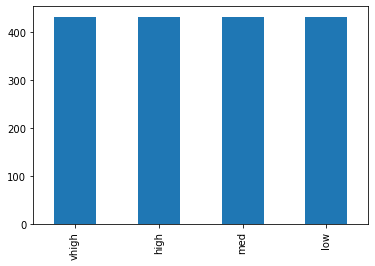

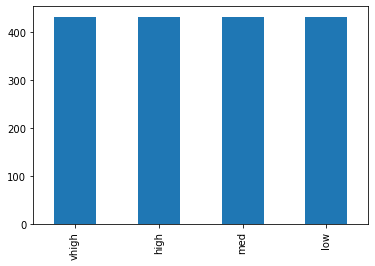

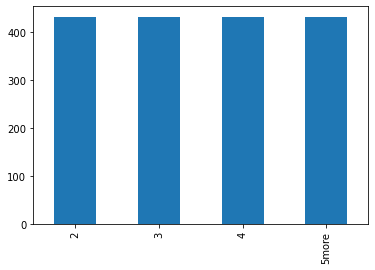

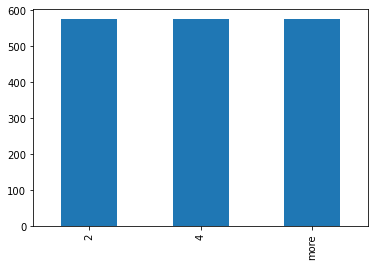

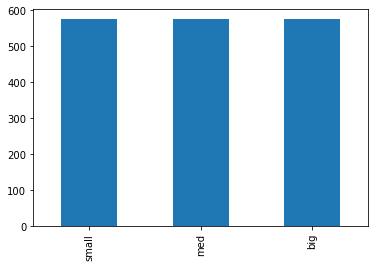

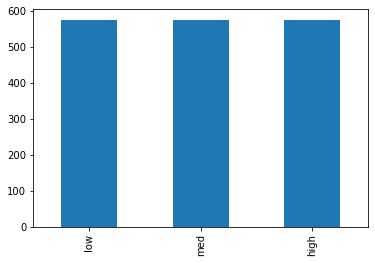

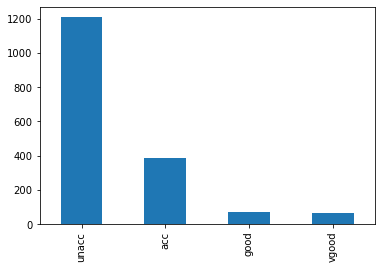

In [12]:
for col in df.columns:
    cat = df[col].value_counts()
    cat.plot(kind = 'bar')
    plt.show()

*Distribution of all the predictor columns seems to be the same.*

In [15]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
df['buying'] = le.fit_transform(df['buying'])
df['maint'] = le.fit_transform(df['maint'])
df['lug_boot'] = le.fit_transform(df['lug_boot'])
df['safety'] = le.fit_transform(df['safety'])

In [16]:
df1 = df[df['class'] == 'unacc']
df2 = df[df['class'] == 'acc']
df3 = df[df['class'] == 'vgood']
df4 = df[df['class'] == 'good']

In [17]:
df['class'] = le.fit_transform(df['class'])

In [18]:
df

,buying,maint,doors,persons,lug_boot,safety,class
0,3,3,2,2,2,1,2
1,3,3,2,2,2,2,2
2,3,3,2,2,2,0,2
3,3,3,2,2,1,1,2
4,3,3,2,2,1,2,2
...,...,...,...,...,...,...,...
1723,1,1,5more,more,1,2,1
1724,1,1,5more,more,1,0,3
1725,1,1,5more,more,0,1,2
1726,1,1,5more,more,0,2,1


In [19]:
df['doors'].unique()

array(['2', '3', '4', '5more'], dtype=object)

In [20]:
df['persons'].unique()

array(['2', '4', 'more'], dtype=object)

## Data Preprocessing

In [21]:
df['doors'] = df['doors'].apply(lambda x: '5' if x == '5more' else x)

In [22]:
df['persons'] = df['persons'].apply(lambda x: '5' if x == 'more' else x)

In [23]:
df.head()

,buying,maint,doors,persons,lug_boot,safety,class
0,3,3,2,2,2,1,2
1,3,3,2,2,2,2,2
2,3,3,2,2,2,0,2
3,3,3,2,2,1,1,2
4,3,3,2,2,1,2,2


## Model

In [24]:
X = df.drop('class', axis = 1)
y = df['class']

In [40]:
from sklearn.model_selection import train_test_split
xtrain, xtest, ytrain, ytest = train_test_split(X, y, test_size = 0.1, random_state = 10)

In [37]:
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import Lasso
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVC
from sklearn.model_selection import ShuffleSplit

def find_best_model_using_gridsearchcv(X,y):
    algos = {
        'SVM' : {
            'model': SVC(),
            'params': {
            }
        },
        'lasso': {
            'model': Lasso(),
            'params': {
                'alpha': [1,2],
                'selection': ['random', 'cyclic']
            }
        },
        'decision_tree': {
            'model': DecisionTreeRegressor(),
            'params': {
                'criterion' : ['squared_error','friedman_mse'],
                'splitter': ['best','random']
            }
        },
        'knn' : {
            'model' : KNeighborsClassifier(),
            'params' : {
                'n_neighbors' : [7]
            }
        }
    }
    scores = []
    cv = ShuffleSplit(n_splits = 5, test_size = 0.2, random_state = 10)
    for algo_name, config in algos.items():
        gs =  GridSearchCV(config['model'], config['params'], cv = cv, return_train_score=False)
        gs.fit(xtrain, ytrain)
        scores.append({
            'model': algo_name,
            'best_score': gs.best_score_,
            'best_params': gs.best_params_
        })

    return pd.DataFrame(scores,columns=['model','best_score','best_params'])

find_best_model_using_gridsearchcv(xtest, ytest)

,model,best_score,best_params
0,SVM,0.776849,{}
1,lasso,-0.004483,"{'alpha': 1, 'selection': 'random'}"
2,decision_tree,0.909171,"{'criterion': 'squared_error', 'splitter': 'be..."
3,knn,0.913826,{'n_neighbors': 7}


*knn gives the best score.*

In [38]:
model = KNeighborsClassifier(n_neighbors = 7)
model.fit(xtrain, ytrain)

KNeighborsClassifier(n_neighbors=7)

In [39]:
model.predict(xtest)

array([2, 0, 2, 2, 0, 2, 2, 2, 2, 2, 2, 0, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2,
       2, 2, 3, 2, 2, 2, 2, 2, 0, 2, 2, 2, 2, 0, 2, 2, 0, 0, 0, 2, 2, 0,
       2, 2, 2, 2, 2, 2, 2, 0, 0, 2, 2, 2, 2, 2, 2, 1, 0, 2, 2, 0, 3, 2,
       0, 2, 2, 0, 2, 2, 0, 2, 2, 0, 2, 2, 2, 0, 2, 2, 2, 2, 2, 2, 2, 0,
       0, 2, 2, 0, 0, 0, 2, 0, 0, 2, 2, 2, 0, 2, 2, 2, 1, 2, 2, 1, 2, 0,
       2, 0, 0, 2, 2, 2, 2, 2, 2, 2, 0, 2, 1, 2, 0, 0, 2, 2, 0, 0, 2, 2,
       2, 2, 2, 2, 2, 0, 0, 2, 2, 2, 2, 2, 2, 2, 0, 2, 2, 0, 2, 2, 0, 2,
       2, 2, 0, 0, 0, 2, 0, 2, 2, 2, 2, 3, 2, 2, 2, 2, 0, 2, 0])